In [1]:
# 1) Business Question, # 2) Data Collection, # 3) Preprocessing, # 4) Model(s) Creation, # 5) Model Evaluation and Comparison , # 6) Conclusion and Future Improvements
#https://www.kaggle.com/c/home-credit-default-risk/data?select=installments_payments.csv

In [2]:
#Dataframe
import pandas as pd
import numpy as np
import math
from datetime import datetime
import scipy
from scipy import stats
#Graph
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
#sklearn & models
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import time
#Data processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from  sklearn.impute import SimpleImputer   
from imblearn.over_sampling import SMOTE
#Print 30 lines
pd.set_option('display.max_rows', 30)

In [3]:
#   Load dataframe
df = pd.read_csv("./data/application_train.csv" )           #index_col=0  ID which is used for mapping other excel files goes to index column
print('original shape: ' , df.shape)
df.drop(columns=['SK_ID_CURR','DAYS_BIRTH'], inplace=True)  #drop ID

#   Missing values
drop_rate = 1   #1 means drop nothing    #0.3 mean the data with 70% more  
drop_col_Cat = drop_col_Num = drop_col_Corr = []
#   Categorical
for col in df.columns:
    if (df[col].isna().sum() / df.shape[0] <= drop_rate )&(type(df[col][0])==str):
        df[col].fillna(  df[col].mode()[0]  ,inplace=True)  #   >>>categorical columns<<<   Minor missing values: replace with mode
    elif (df[col].isna().sum() / df.shape[0] > drop_rate )&(type(df[col][0])==str):
        drop_col_Cat.append(col)                          #   >>>categorical columns<<<   Huge missing values:  drop
df.drop(columns=drop_col_Cat , inplace=True)
#   Numerical
drop_col_Num = [col for col in df.columns if (df[col].isna().sum() / df.shape[0] > drop_rate )&((type(df[col][0])==np.int64)|(type(df[col][0])==np.float64))]
df.drop(columns=drop_col_Num , inplace=True)    #Drop columns with many missing values
df[list(df.select_dtypes(include=["int64","float64"]).columns)]  =  pd.DataFrame(   SimpleImputer(missing_values=np.NaN, strategy='mean').fit_transform(  df[list(df.select_dtypes(include=["int64","float64"]).columns)].values),index = df.index,columns=  list(df.select_dtypes(include=["int64","float64"]).columns) )      # Replace missing values with mean

print('Columns that is dropped due to missing values with % of less than',drop_rate,': \n','Cat: ',drop_col_Cat,'\nNum: ',drop_col_Num,'\nCorr: ',drop_col_Corr)

#   Imbalanced dataset<<<   
df.drop(df.query('TARGET == 0').sample(((df.query('TARGET == 0').shape[0])-1*(df.query('TARGET == 1').shape[0]))).index,inplace=True)  #Downscale the data with '0'
print(df.TARGET.value_counts())

X = df.drop(columns=['TARGET'])
y = df[['TARGET']]

#   One Hot Encoder
X= pd.get_dummies(X, drop_first=True)       

print('X.shape = ' , X.shape)
X.head()

original shape:  (307511, 122)
Columns that is dropped due to missing values with % of less than 1 : 
 Cat:  [] 
Num:  [] 
Corr:  []
0.0    24825
1.0    24825
Name: TARGET, dtype: int64
X.shape =  (49650, 225)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-637.0,-3648.0,-2120.0,12.061091,...,0,0,0,0,0,0,0,1,0,0
15,0.0,157500.0,299772.0,20160.0,247500.0,0.020713,-1157.0,-3494.0,-1368.0,17.000000,...,0,0,0,0,0,0,1,0,0,0
26,0.0,112500.0,979992.0,27076.5,702000.0,0.018029,-2628.0,-6573.0,-1827.0,12.061091,...,0,0,0,0,0,0,0,0,1,1
40,0.0,202500.0,1193580.0,35028.0,855000.0,0.025164,-1262.0,-1182.0,-1029.0,12.061091,...,0,0,0,0,0,0,0,1,0,0
42,0.0,135000.0,288873.0,16258.5,238500.0,0.007305,-3597.0,-45.0,-4409.0,12.061091,...,0,0,0,0,0,0,1,0,0,0


In [4]:
import time
start_time = time.time()

print('-------RamdonForest (200 estimators)-------')
#   Finding 1:      No change when we remove columns with relatively low correlation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42 , stratify=y)

rnd_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42 )  #, max_leaf_nodes=16, bootstrap=False
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

#Step 6:    Classification Metrics        #---------------------Score---------------------#
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)

print("Process finished --- %s seconds ---" % (time.time() - start_time))

-------RamdonForest (200 estimators)-------
confusion_matrix:    
 [[6903 3027]
 [3210 6720]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.68      0.70      0.69      9930
         1.0       0.69      0.68      0.68      9930

    accuracy                           0.69     19860
   macro avg       0.69      0.69      0.69     19860
weighted avg       0.69      0.69      0.69     19860

accuracy_score:  
 0.68595166163142  ; with data size of  (29790, 225)
Process finished --- 3.3626043796539307 seconds ---


In [5]:
import time
start_time = time.time()

print('-------RamdonForest (2000 estimators)-------')
#   Finding 1:      No change when we remove columns with relatively low correlation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42 , stratify=y)

rnd_clf = RandomForestClassifier(n_estimators=2000, n_jobs=-1, random_state=42 )  #, max_leaf_nodes=16, bootstrap=False
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

#Step 6:    Classification Metrics        #---------------------Score---------------------#
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)

print("Process finished --- %s seconds ---" % (time.time() - start_time))

-------RamdonForest (2000 estimators)-------
confusion_matrix:    
 [[6901 3029]
 [3142 6788]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.69      0.69      0.69      9930
         1.0       0.69      0.68      0.69      9930

    accuracy                           0.69     19860
   macro avg       0.69      0.69      0.69     19860
weighted avg       0.69      0.69      0.69     19860

accuracy_score:  
 0.6892749244712991  ; with data size of  (29790, 225)
Process finished --- 32.05206036567688 seconds ---


In [ ]:
from sklearn.decomposition import PCA

pca = PCA()  
X_train = pca.fit_transform(X_train)  
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_  
print(explained_variance)

In [6]:
import time
start_time = time.time()

print('-------XGboost-------')
#Finding1:  SMOTE: too many False Negative
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size =0.2, random_state=42, stratify = y)
print(X.shape)

model =XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Classification Metrics
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)


print("Process finished --- %s seconds ---" % (time.time() - start_time))

-------XGboost-------
(49650, 225)
[20:03:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion_matrix:    
 [[3350 1615]
 [1556 3409]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.68      0.67      0.68      4965
         1.0       0.68      0.69      0.68      4965

    accuracy                           0.68      9930
   macro avg       0.68      0.68      0.68      9930
weighted avg       0.68      0.68      0.68      9930

accuracy_score:  
 0.6806646525679758  ; with data size of  (39720, 225)
Process finished --- 3.508706569671631 seconds ---


In [20]:
from sklearn import preprocessing
#get_score identifies the features that the model put the highest weight on
importance_df = model.get_booster().get_score(importance_type='weight')

features_impt_xgb = pd.DataFrame(list(importance_df.items()), columns = ['FEATURE' , 'SCORE'])

print(features_impt_xgb.sort_values('SCORE', ascending = False).head(10))

                       FEATURE  SCORE
14             DAYS_ID_PUBLISH    258
1                 EXT_SOURCE_2    253
15           DAYS_REGISTRATION    209
8                DAYS_EMPLOYED    207
0                 EXT_SOURCE_3    204
2                  AMT_ANNUITY    204
3                 EXT_SOURCE_1    194
11                  AMT_CREDIT    180
32      DAYS_LAST_PHONE_CHANGE    179
29  REGION_POPULATION_RELATIVE    137


In [7]:
print('-------LogisticRegression-------')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)       #
print('X_train shape is:  ', X_train.shape)

logmodel = LogisticRegression()     # Create instance (i.e. object) of LogisticRegression
logmodel.fit(X_train, y_train)      # Fit the model using the training data
y_pred = logmodel.predict(X_test)   #Predicting the target for test data

#Classification Metrics
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)

-------Regression model-------
X_train shape is:   (39720, 225)
confusion_matrix:    
 [[3187 1778]
 [2404 2561]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.57      0.64      0.60      4965
         1.0       0.59      0.52      0.55      4965

    accuracy                           0.58      9930
   macro avg       0.58      0.58      0.58      9930
weighted avg       0.58      0.58      0.58      9930

accuracy_score:  
 0.5788519637462236  ; with data size of  (39720, 225)


In [15]:
print('-------LogisticRegression ( low classifier to reduce over fitting)-------')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)       #
print('X_train shape is:  ', X_train.shape)

logmodel = LogisticRegression(C = 0.0001)     # Create instance (i.e. object) of LogisticRegression
logmodel.fit(X_train, y_train)      # Fit the model using the training data
y_pred = logmodel.predict(X_test)   #Predicting the target for test data

#Classification Metrics
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)

-------LogisticRegression ( low classifier to reduce over fitting)-------
X_train shape is:   (39720, 225)
confusion_matrix:    
 [[3127 1838]
 [2332 2633]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.57      0.63      0.60      4965
         1.0       0.59      0.53      0.56      4965

    accuracy                           0.58      9930
   macro avg       0.58      0.58      0.58      9930
weighted avg       0.58      0.58      0.58      9930

accuracy_score:  
 0.5800604229607251  ; with data size of  (39720, 225)


In [18]:
print('-------KNN-------')
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)       #
#SMOTE: too slow , run like 1 hour for data set with ~300k size
    
knn = KNeighborsClassifier(n_neighbors=k)   #Make an object
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

#Classification Metrics
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)
print("Process finished --- %s seconds ---" % (time.time() - start_time))

-------KNN-------
confusion_matrix:    
 [[3073 1892]
 [2295 2670]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.57      0.62      0.59      4965
         1.0       0.59      0.54      0.56      4965

    accuracy                           0.58      9930
   macro avg       0.58      0.58      0.58      9930
weighted avg       0.58      0.58      0.58      9930

accuracy_score:  
 0.5783484390735146  ; with data size of  (39720, 225)
Process finished --- 7.235802412033081 seconds ---


In [ ]:
k_range = range(1,31)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred_knn))
print(scores)
plt.plot(k_range,scores)

In [9]:
print('AdaBoost (unlimitted depth and leaf)')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 , stratify=y)

ada_clf = AdaBoostClassifier(
    #DecisionTreeClassifier(max_depth=2), n_estimators=200,learning_rate=0.05, random_state=42)
    DecisionTreeClassifier(), n_estimators=200,learning_rate=0.05, random_state=42)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)

#5.1 - Hyperparameter Tuning (Max Depth)#---------------------Modelling---------------------#  Find Max depth
parameters = {'max_depth' : list(range(1,11))}
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(DecisionTreeClassifier(),param_grid=parameters,cv=10)
search.fit(X_train,y_train)
print('search.best_score_:' , search.best_score_)
print('search.best_params_:', search.best_params_)

#Classification Metrics
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)

AdaBoost (unlimitted depth and leaf)
search.best_score_: 0.658257804632427
search.best_params_: {'max_depth': 6}
confusion_matrix:    
 [[2925 2040]
 [2032 2933]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.59      0.59      0.59      4965
         1.0       0.59      0.59      0.59      4965

    accuracy                           0.59      9930
   macro avg       0.59      0.59      0.59      9930
weighted avg       0.59      0.59      0.59      9930

accuracy_score:  
 0.5899295065458208  ; with data size of  (39720, 225)


In [10]:
print('LGBMClassifier')

LGBMClassifier


In [11]:
#Presentation (Correlation) ------------ part 1
df = pd.read_csv("./data/application_train.csv" )
df_corr = pd.DataFrame( df.corr()['TARGET'])
df_corr['MissingValue'] = [df[list(df_corr.index)[x]].isna().sum() for x in range(len(pd.DataFrame(df_corr)['TARGET']))]
#df_corr = df_corr[df_corr['MissingValue']>30000].sort_values(by=['TARGET'])
df_corr['Abs_correlation'] = abs(df_corr['TARGET'])
df_corr.sort_values(by=['Abs_correlation'],ascending=False,inplace=True)
#"','".join(list(df_corr.index))

#Presentation (Correlation) ------------ part 2
df_corr_top20 = df_corr[(df_corr['Abs_correlation']>=   df_corr.iloc[19,2]    )]    #Get top 20
df_corr_top20.drop('TARGET',inplace=True)
df_corr_top20.columns=['Correlation','Count_MissingValues','Abs_correlation']
print(df_corr_top20)

                             Correlation  Count_MissingValues  Abs_correlation
EXT_SOURCE_3                   -0.178919                60965         0.178919
EXT_SOURCE_2                   -0.160472                  660         0.160472
EXT_SOURCE_1                   -0.155317               173378         0.155317
DAYS_BIRTH                      0.078239                    0         0.078239
REGION_RATING_CLIENT_W_CITY     0.060893                    0         0.060893
REGION_RATING_CLIENT            0.058899                    0         0.058899
DAYS_LAST_PHONE_CHANGE          0.055218                    1         0.055218
DAYS_ID_PUBLISH                 0.051457                    0         0.051457
REG_CITY_NOT_WORK_CITY          0.050994                    0         0.050994
FLAG_EMP_PHONE                  0.045982                    0         0.045982
DAYS_EMPLOYED                  -0.044932                    0         0.044932
REG_CITY_NOT_LIVE_CITY          0.044395            

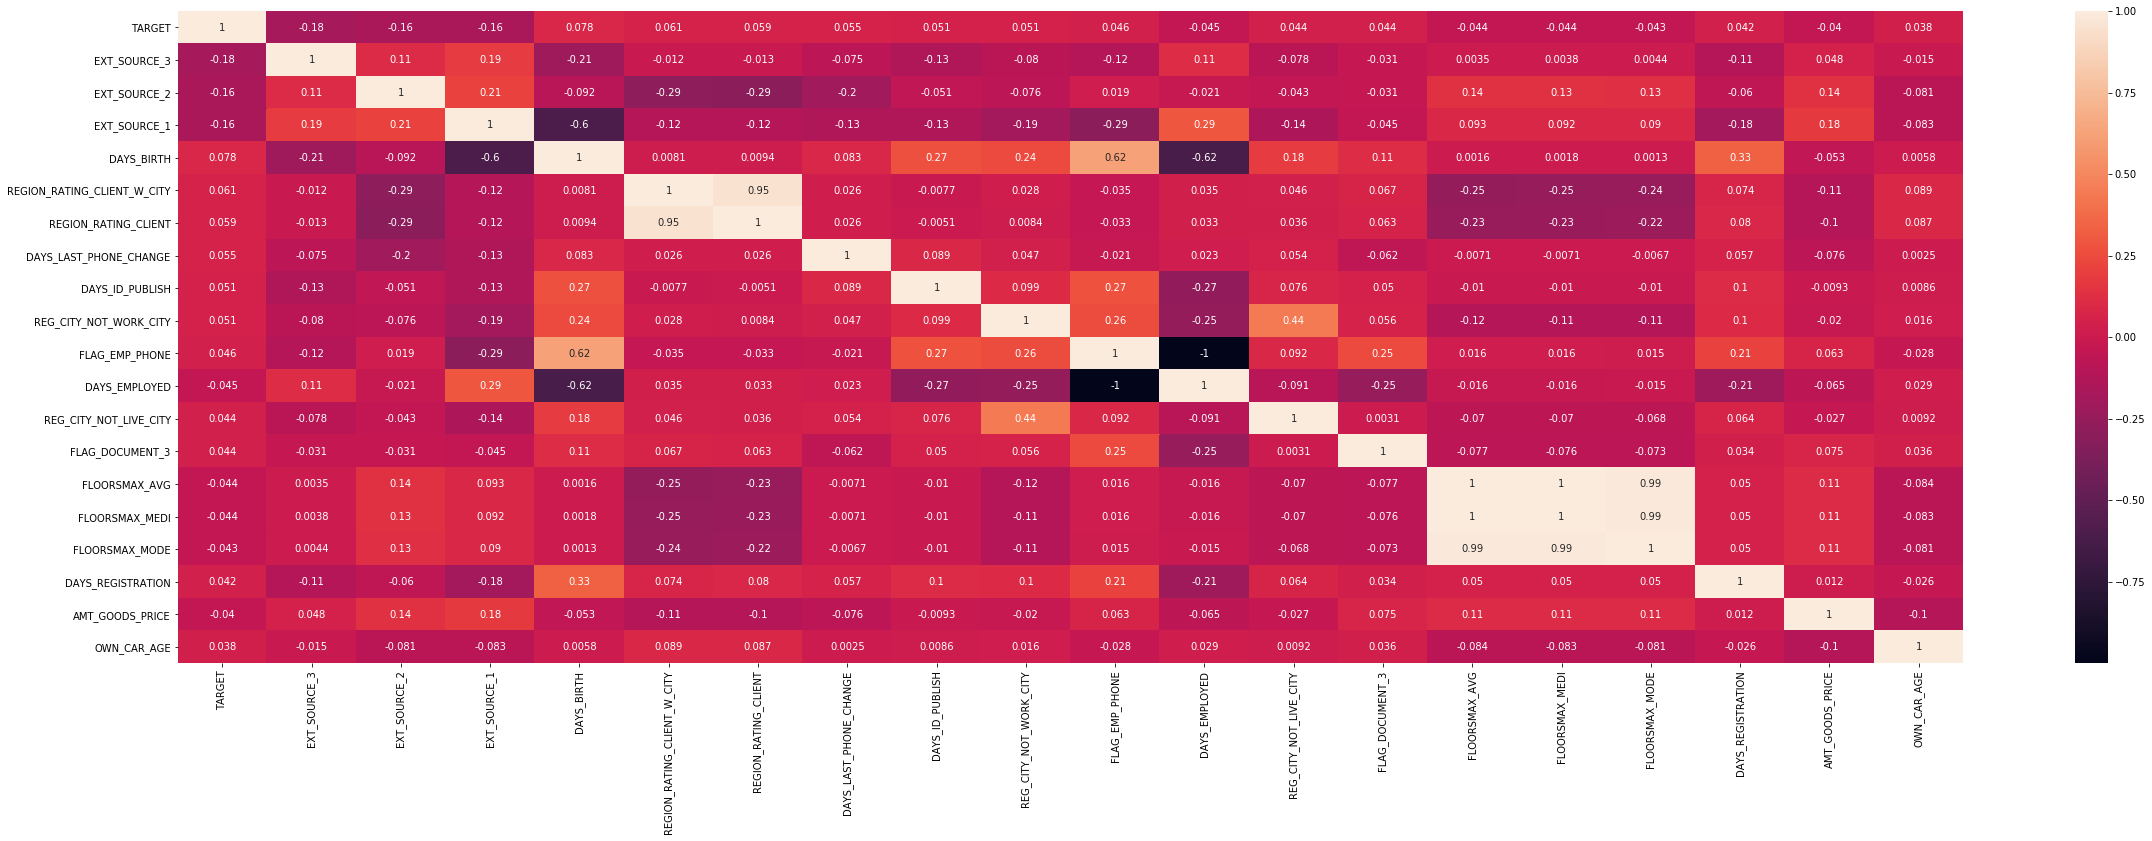

In [13]:
#Heatmap for correlation
top20 = list(df_corr_top20.index)
df_top20 = df[top20]
df_top20.insert(0, 'TARGET', df['TARGET'])
plt.figure(figsize=(40,12))
sns.heatmap(df_top20.corr(),annot=True)

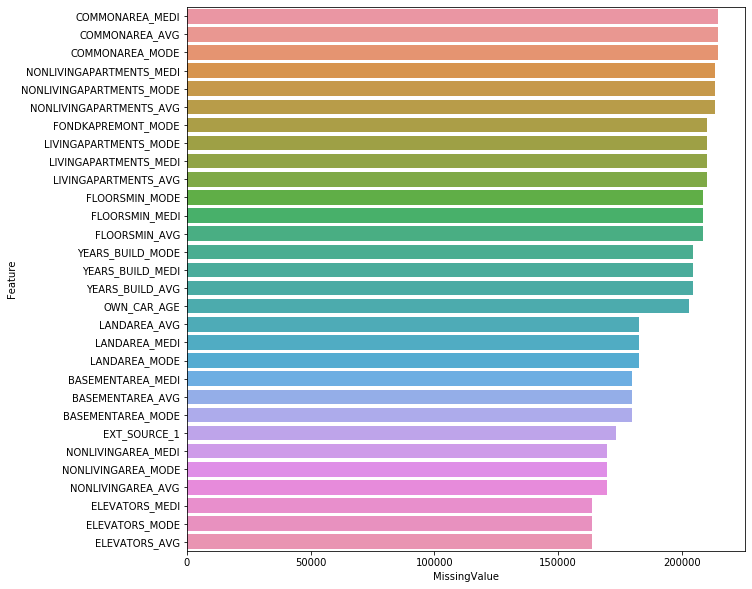

In [12]:
#Presentation (Missing Values) 
df = pd.read_csv("./data/application_train.csv" )

MissingColumns = []
MissingValues = []
for col in df.columns:
    if int(df[col].isna().sum()) != 0:
        MissingColumns.append(col)
        MissingValues.append(df[col].isna().sum())
missing_df = pd.DataFrame(list(zip(MissingColumns, MissingValues)), columns =['Feature', 'MissingValue']) 
missing_df.sort_values(by=['MissingValue'],ascending=False,inplace=True)
missing_df.reset_index(drop=True, inplace=True)
#sns.factorplot(df=missing_df , x = 'MissingValue' , y = 'Feature' )
missing_df.head(30)
fig , ax = plt.subplots(figsize = (10,10))
sns.barplot(data=missing_df.head(30) , x = 'MissingValue' , y = 'Feature' )